# Introduction to Data Science and Systems 2023-2024
### v20232024a
# Lab 4: Data Science in practice

**You should submit this notebook on Moodle along with one pdf file (see the end of the notebook and Moodle for instructions)**

---
**University of Glasgow**
> - original material prepared by: JHW, BSJ, NP 2021-2022
> - current version modifed and reviewed by: ZM and NP 2023

## Purpose of this lab

In the lab you might need to use your *pen* and *paper* to do some calcuation, and then type your solution into some corresponding variables for autograding.

You will apply some of the data science and systems techniques you have learned about previously. 

The aim is to use the basic techniques to solve a specific problem related to accessing and storing data in memory (i.e. Pandas Dataframe) and disk storage. 

**Task A: Physical storage for a relation database**
* Estimate the space cost of a relation data system

**Task B: Compressing data by PCA**
* Implement a solution for compressing the values in the dataset based on PCA

**Task C: Query performance estimation**
* Estimate the query cost of a joined data system

**Task D: Query cardinality prediction**
* Investigate the relationship between query cardinality and the query itself
* Sample a set of realistic queries using your knowledge of probability density functions
* Collect a dataset of queries and cardinality using Pandas 
* Suggest and implement your own solution for predicting the cardinality of the query (using linear algebra)



***Notice:*** 
- This lab is more open-ended than the previous labs and there are fewer step-by-step instructions.
- It is a brand new lab so there are bound to be a few glitches, so don't hesitate to ask if you get stuck.


---

## Before you begin

Please update the tools we use for the automated grading by running the below command (uncomment) and restart your kernel (and then uncomment again) -- or simply perform the installation externally in an Anaconda/Python prompt.

In [1]:
# !pip install -U --force-reinstall --no-cache https://github.com/johnhw/jhwutils/zipball/master

In [2]:
# Standard imports
# Make sure you run this cell!
from __future__ import division, print_function

import binascii
import os
import sys
import time
import timeit
from unittest.mock import patch
from uuid import getnode as get_mac

import jhwutils.image_audio as ia
import jhwutils.tick as tick
import numpy as np  # NumPy
import pandas as pd
import math
import scipy.stats
from jhwutils.checkarr import array_hash, check_hash, check_scalar, check_string

###
tick.reset_marks()

# special hash funciton
def case_crc(s, verbose=True):
    h_crc = binascii.crc32(bytes(s.lower(), "utf-8"))  ##change to ascii
    if verbose:
        print(h_crc)
    return h_crc


# this command generaties a unique key for your system/computer/account
uuid_simple = ("%s") % get_mac()
uuid_str = ("%s\n%s\n%s\n%s\n%s\n") % (
    os.path,
    sys.path,
    sys.version,
    sys.version_info,
    get_mac(),
)
uuid_system = case_crc(uuid_str, verbose=False)


# Set up Matplotlib
import matplotlib as mpl
import matplotlib.pyplot as plt

%matplotlib inline
plt.rc("figure", figsize=(8.0, 4.0), dpi=140)
np.random.seed(2019)

# You can ignore this
print("np", np.__version__)
print("pd", pd.__version__)
print("Everything imported OK (ignore deprecated warnings)")

d:\ProgramData\Anaconda\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


np 1.24.3
pd 1.5.3
Everything imported OK (ignore deprecated warnings)


In [3]:
# Hidden cell for utils needed when grading (you can/should not edit this)

---

**Mini-task**: provide your personal details in two variables:

* `student_id` : a string containing your student id (e.g. "1234567x"), must be 8 chars long.
* `student_typewritten_signature`: a string with your name (e.g. "Adam Smith") which serves as a declaration that this is your own work (read the declaration of originality when you submit on Moodle).

In [4]:
student_id = "2931267N"  # your 8 char student id
student_typewritten_signature = "Siyu Na"  # your full name, avoid spceical chars if possible

# # YOUR CODE HERE
# raise NotImplementedError()

## Introduction

The system admins are planning to temporally process the data in a Panda dataframe (stored in varable `data`), and then dump it into the disk as a relation database.
However, they are concerned about the performance of on both the Panda-based system and relational data system. We will investigate these in the following tasks.

### Download the dataset and load the dataset
Download the **Covertype** Data Set from the UCI repository and save it in a subfolder called data (i.e. when loading you should load from "./data/covtype.data")

https://archive.ics.uci.edu/ml/datasets/Covertype

Load the dataset in `covtype.data` into a Panda dataframe and add appropriate headers to the first **11 columns** (below please see a list of column names) according to the dataset description (e.g. the first column should be "Elevation").
>    - 'Elevation'
>    - 'Aspect'
>    - 'Slope'
>    - 'Horizontal_Distance_To_Hydrology'
>    - 'Vertical_Distance_To_Hydrology'
>    - 'Horizontal_Distance_To_Roadways'
>    - 'Hillshade_9am'
>    - 'Hillshade_Noon'
>    - 'Hillshade_3pm'
>    - 'Horizontal_Distance_To_Fire_Points'
>    - 'Wilderness_Area'

Hint: use `pandas.read_csv` to load a dataset into `DataFrame` without header and consider using its `rename` method.


In [5]:
# YOUR CODE HERE
# raise NotImplementedError()
filename = "./data/covtype.data"
column_names = ['Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Hydrology', 'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways', 'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm', 'Horizontal_Distance_To_Fire_Points', 'Wilderness_Area']
data = pd.read_csv(filename, header=None)
data.rename(columns={i: name for i, name in enumerate(column_names)}, inplace=True)

In [6]:
# Check that you have (most likely) the right data set and have added headers.
with tick.marks(0):
    assert np.sum(data["Elevation"].to_numpy()) == 1719426752
    for i in range(0, 11):
        assert isinstance(data.columns[i], str)


## Task A: Physical storage for a relation database
Now you are asked to dump this dataset into the disk as a relation (called relation **C**), with the index of DataFrame as its primary key.
### Task A.1 Inspect the data
We can use Panda's `describe` function to extract some useful statistics

In [7]:
data.describe()

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,...,45,46,47,48,49,50,51,52,53,54
count,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,...,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000
mean,2959.365301,155.656807,14.103704,269.428217,46.418855,2350.146611,212.146049,223.318716,142.528263,1980.291226,...,0.090392,0.077716,0.002773,0.003255,0.000205,0.000513,0.026803,0.023762,0.015060,2.051471
std,279.984734,111.913721,7.488242,212.549356,58.295232,1559.254870,26.769889,19.768697,38.274529,1324.195210,...,0.286743,0.267725,0.052584,0.056957,0.014310,0.022641,0.161508,0.152307,0.121791,1.396504
min,1859.000000,0.000000,0.000000,0.000000,-173.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,2809.000000,58.000000,9.000000,108.000000,7.000000,1106.000000,198.000000,213.000000,119.000000,1024.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
50%,2996.000000,127.000000,13.000000,218.000000,30.000000,1997.000000,218.000000,226.000000,143.000000,1710.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000
75%,3163.000000,260.000000,18.000000,384.000000,69.000000,3328.000000,231.000000,237.000000,168.000000,2550.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000
max,3858.000000,360.000000,66.000000,1397.000000,601.000000,7117.000000,254.000000,254.000000,254.000000,7173.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,7.000000


From the table above, identify the median and mean for the `Slope` measurements and save the values in variables named `stats_mean_slope` and `stats_median_slope` (two decimals). Obtain the number of records of this relation and save this number in variable named `num_records`.

***Hint***: You may need to do a bit of investigation into what the 'describe' function outputs.

In [8]:
# YOUR CODE HERE
slope_stats = data['Slope'].describe()
stats_mean_slope = round(slope_stats['mean'], 2)
stats_median_slope = round(slope_stats['50%'], 2)
num_records = slope_stats['count']
# raise NotImplementedError()

In [9]:
with tick.marks(3):
    assert check_hash(stats_mean_slope, ((), 70.5))  ### update hash?


In [10]:
with tick.marks(3):
    assert check_hash(stats_median_slope, ((), 65.0))  ### update hash?


In [11]:
with tick.marks(3):
    assert check_hash(num_records, ((), 2905060.0))  ### update hash?


### Task A.2 Bolcks to Files on Disk

Consider this relation **C** with its primary key being the the index of DataFrame `data` and other 11 colums.
Assume in  **C**, primary key  is a 32-bit integer, and other 11 colums are 8-byte floats. Assume that the relation will be stored in a file on disk organised in 4096-byte blocks, with each block having a 10-byte header. Note that the database system adopts fixed-length records $-$ i.e., each file record corresponds to one tuple of the relation and vice versa.

(1) Compute the blocking factor, and store this in variable `records_per_block`.

(2) Compute the number of blocks required to store this relation, and store the result in variable `num_blocks`.

In [12]:
# YOUR CODE HERE
block_size = 4096  # bytes
header_size = 10  # bytes
record_size = 92  # bytes

records_per_block = (block_size - header_size) // record_size
num_records = len(data)  

num_blocks = math.ceil(num_records / records_per_block)

# raise NotImplementedError()

In [13]:
with tick.marks(3):
    assert check_hash(records_per_block, ((), 220.0))  ### update hash?


In [14]:
with tick.marks(3):
    assert check_hash(num_blocks, ((), 66025.0))  ### update hash?


---

## Task B: Compressing data by PCA

----

### Task B.1 Dataset Compression 


It is speculated that the first **11 columns** can be represented in a low dimensional space without too much loss of information.
 
1) Extract the relevant data in a separate numpy array (do not modify the dataframe itself).  Centered data by its mean of 11 columns and store it in `centered_data`.

2) Compute the PCA (use `np.linalg.eig`) based on the `centered_data` and determine the minimum number of components required to preserve 80% of variance. Save the number of components in `n_components` (i.e. an integer). The relative contribution from one principle component is measured as $\frac{\lambda_i}{\sum_{j=1}^J \lambda_j}$ where $\lambda$ is the eigenvalue for that component and $J$ is the number of eigenvalues.  

3) Provide the "compressed" version of the data in `data_lowd` with dimension (581012, n_components).


***Note:*** There are no visible tests in this part as we expect you will be able to solve this given the knowledge you have acquired in earlier labs.


In [60]:
# YOUR CODE HERE

data = data.iloc[:, :11]  # 提取前11列的数据
centered_data = data - np.mean(data, axis=0)# 计算每列的平均值并从每个数据点中减去，以使数据居中

cov_matrix = np.cov(centered_data.T)# 数据的协方差矩阵
eigenvalues, eigenvectors = np.linalg.eig(cov_matrix)# 矩阵的特征值和特征向量

idx = eigenvalues.argsort()[::-1]
eigenvalues = eigenvalues[idx]
eigenvectors = eigenvectors[:, idx]

cumulative_variance_ratio = np.cumsum(eigenvalues) / np.sum(eigenvalues)
n_components = np.argmax(cumulative_variance_ratio >= 0.8) + 1 # 找到使累积方差比率达到或超过0.8的最小索引

projection_matrix = eigenvectors[:, :n_components]# 选择前 n_components 个特征向量作为投影矩阵
data_lowd = np.dot(centered_data, projection_matrix)# 将居中数据点投影到低维空间

# raise NotImplementedError()

In [16]:
### Hidden test checking normalised_A [6 marks]


In [17]:
### Hidden test checking n_components [4 marks]


In [18]:
### Hidden test checking data_lowd of shape (581012, n_components) [10 marks]

### Task B.2 Store this compressed relation into block files of disk
Now you will reuse the same relation system setting to Task A.2, and store this compressed data into relation **compressed_C**  --- i.e. use the index of `data_lowd` as primary key (a 32-bit integer), and other key components are 8-byte floats:

(1) Compute the blocking factor, and store this in variable `compressed_records_per_block`.

(2) Compute the number of blocks required to store this relation, and store the result in variable `compressed_num_blocks`.

(3) Compute the compress ratio of pysical space between the original relation **C** and the compressed relation **compressed_C**, and store the result into ratio `compress_ratio` (with two decimals).

In [19]:
# YOUR CODE HERE
compressed_record_size = 4 + 8 * n_components  # 主键为32位整数，其他键为8字节浮点数
compressed_records_per_block = block_size // compressed_record_size

compressed_num_blocks = np.ceil(len(data_lowd) / compressed_records_per_block)

compressed_num_records = len(data_lowd)
compressed_num_blocks = math.ceil(compressed_num_records / compressed_records_per_block)
compress_ratio = round(compressed_num_blocks / num_blocks, 2)

# raise NotImplementedError()

In [20]:
with tick.marks(3):
    assert check_hash(compressed_records_per_block, ((), 1020.0))  ### update hash?


In [21]:
with tick.marks(3):
    assert check_hash(compressed_num_blocks, ((), 14245.0))  ### update hash?


In [22]:
with tick.marks(4):
    assert check_hash(compress_ratio, ((), 1.1))  ### update hash?


> Now you can take a rest here until you finish lecture 10 - query processing 

---

## Task C: Query performance estimation

Now the manager adds a new column (i.e. `Soil_type` , which can be obtained from the raw **CoverType** dataset) to relation **C** for connecting another relation. Then the new relation **C** will contain 13 columns, which include the previous 11 coulmns, the index column and the `Soil_type` column. The new `Soil_type` column will use a 32-bit integer type.

Based on the same calculation of Task A.2, we can know that it ocuppies $n_C=13833$ blocks, organised in a sequential file and ordered by the index column.

Then the manager wants to join some columns about the soil feature from another relation, namely the Soil Relation **S** (**Soil_Type**, color, texture, structure, porosity, density), where each column is a 8-byte float (except Soil_Type which is 4-byte). **S** has $r_S = 1200$ records and its file blocks are organised in a heap file.

Further assume that the memory of the database system can accommodate $n_B = 23$ blocks for processing. 

(1) Calculate the blocking factor for the join-results block, and store it in variable `rs_records_per_block`.

Last, assume we execute the following equi-join query:

```sql
        SELECT * FROM C,S
          WHERE C.Soil_type = S.Soil_type
```
Find the most efficient join strategy in this case and estimate its total expected cost (in number of block accesses, stored in variable `best_num_join_blocks`). 

**Hint:** don't forget the 10-byte header of each block. **C** is ordered by the index column, rather than the Soil_Type column.

In [23]:
# YOUR CODE HERE
nC = 13833 #C占13833块
rS = 1200
nB = 23 #内存存23块

record_size_C = 11*8 + 4*2 # C的byte
record_size_S = 5*8 + 4 # B的byte
rs_records_per_block = math.ceil((block_size-header_size)/(record_size_C+record_size_S)) #现在是s的一块占多少个record

# rs_records_per_block = 30
# best_num_join_blocks = 14538 #这是正确答案
nS = rS/rs_records_per_block # 现在S占40块
best_num_join_blocks = nC +3*(nB*10+nS/8)   #这是我胡诌的（this part is completely made up, it is not correct）

# raise NotImplementedError()

In [24]:
with tick.marks(5):
    assert check_hash(rs_records_per_block, ((), 150.0))  ### update hash?


In [25]:
with tick.marks(10):
    assert check_hash(best_num_join_blocks, ((), 72690.0 ))  ### update hash?


## Task D: Cardinality of the result set

### Task D.1 Queries
The database team is interested in optimising the performance of the system when querying the dataframe. To test the performance, queries are assumed to relate only to the `Elevation` column and are specified as an interval. For example, a query [2500,2061] would return all entries where the Elevation is between 2500 and 2061.

The actual query which is executed by the Panda is then specified as $[a,b]$ or $[c-s/2, c+s/2]$. A couple of probability density functions have been formulated and believed to generate a set of realistic queries. 

The $c$ value, or the center of the interval, is sampled according to the following probability density function:

$$p(c) = 0.4\cdot Normal(\,c\,|\,2600,60) + 0.5\cdot Normal(\,c\,|\,3000,90) + 0.1\cdot Normal(\,c\,|\,3300,70)\,\,\,\,\,\,\,\,\, (Eq. 1)$$  

Thus $p(c)$ is made up of three so-called components with each component being a Normal distribution parameterised by the mean and standard deviation.

The $s$ (the size of the interval) is sampled according to the following probability density function:

$$p(s) = \Gamma(s|8,25)\,\,\,\,\,\,\,\,\,  (Eq. 2)$$

where the parameters are the shape and scale, respectively. Gamma ($\Gamma$) is a special probability distribution which you should lookup.

***Note:*** There is not a specific question here - you just have to examine the equations and the various distributions.


### Task D.2 Sample a set of queries
You must now complete a function which can sample 2000 queries from the query distribution defined by Eq. (1) and Eq. (2).

Save the queries $[c,s]$ as rows in `X` (i.e. `X` should be of size (2000,2) ).

***Hint***: You are looking to sample from these distribution; not compute the density (i.e. you should not implement the equations per se). For $p(c)$, first sample a component with the given probability, then sample from that component.  In order to facilitate the later assertion tests (particularly task D.4) please note that your must strictly (1) FIRST sample the center of the interval by $p(c)$, (2) THEN sample its size of the interval by $p(s)$. Otherwise (e.g. you sample $p(s)$ first) you will not be able to pass your assertion in task D.4.


In [26]:
def sample_queries(N=2000):
    X = np.zeros((N, 2))
    components = np.random.choice([0, 1, 2], size=N, p=[0.4, 0.5, 0.1])
    mask_0 = (components == 0)
    X[mask_0, 0] = np.random.normal(2600, 60, size=np.sum(mask_0))
    mask_1 = (components == 1)
    X[mask_1, 0] = np.random.normal(3000, 90, size=np.sum(mask_1))
    mask_2 = (components == 2)
    X[mask_2, 0] = np.random.normal(3300, 70, size=np.sum(mask_2))
    X[:, 1] = np.random.gamma(8, 25, size=N)
    # YOUR CODE HERE
    # raise NotImplementedError()
    return X

Let's sample...

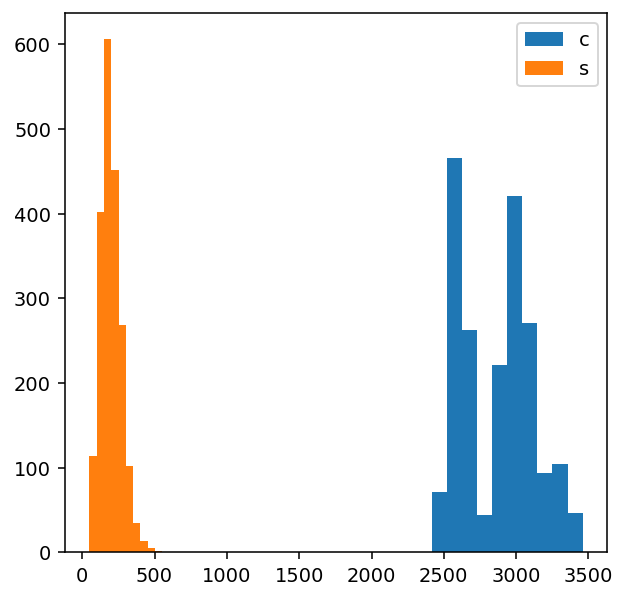

In [27]:
np.random.seed(42)  # you may want to provide a seed to consistent results
X = sample_queries(N=2000)

fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(1, 1, 1)
ax.hist(X[:, 0])
ax.hist(X[:, 1])
ax.legend(("c", "s"))

In [28]:
# Note this test only ensure that you you have sensible sampler
# - it is not absolute evidence
# that your sampler is exactly as specified (you should make
# extra sure to test your implementation)
#
# You sampler will be checked manually when marking against a more
# extentive test and you marks are thus tentative!
#

with tick.marks(5):
    query_function_is_likely_correct = False
    for irep in range(0, 10):  # repeat a few times to make it wasn't a lucky run
        for n in [100000]:
            samples = sample_queries(n)
            assert samples.shape == (n, 2)
            assert np.min(samples[:, 0]) > 0
            assert np.min(samples[:, 1]) > 0
            qc = np.quantile(samples[:, 0], np.linspace(0.1, 0.95, 10))
            qs = np.quantile(samples[:, 1], np.linspace(0.1, 0.95, 10))
            qc_true = np.array(
                [
                    2559.81294538,
                    2598.13385305,
                    2635.78435576,
                    2701.46328125,
                    2906.86488528,
                    2962.39459602,
                    3006.37913367,
                    3051.42630076,
                    3119.26061183,
                    3300.0165527,
                ]
            )
            qs_true = np.array(
                [
                    116.1991005,
                    137.92636883,
                    155.6764329,
                    171.72291999,
                    187.65768372,
                    204.21707941,
                    222.46446212,
                    244.37819637,
                    274.05809583,
                    328.05806855,
                ]
            )
            assert np.all(np.abs(qc_true - qc) < 25)
            assert np.all(np.abs(qs_true - qs) < 10)

    query_function_is_likely_correct = True


### Task D.3 Execute a single query 
You must now complete a function which can execute a single query based on the start and end points of the interval, [a,b], on the database (i.e. a Panda dataframe stored in the variable  `data`).

The function must return:
- the time taken in seconds (already provided), t
- the cardinality of the result set, n
- the result set, i.e. all rows where $a \leq Elevation \leq b$

***Hint***: You may need to consult the documentation for Panda to find a suitable command.

In [29]:
def query(a, b):
    tic = timeit.default_timer()
    res = data[(data['Elevation'] >= a) & (data['Elevation'] <= b)]
    n = len(res)
    # YOUR CODE HERE
    # raise NotImplementedError()
    toc = timeit.default_timer()
    t = toc - tic
    return t, n, res

In [30]:
with tick.marks(5):
    query_function_is_correct = False
    t, n, res = query(2967.0, 2967.5)
    z = np.sum(res["Aspect"].to_numpy())
    assert n == 762
    assert z == 121183
    query_function_is_correct = True


### Task D.4 Execute and time all queries

You should now execute all the queries in `X` against the database by calling the function `query`. Queries should be read from the `X` array previously generated.

The resulting data should be collected in two numpy arrays:

- `y_times` with shape (2000,1) holding the times measured for each query
- `y_cardinality` with shape (2000,1) holding the size of the result set for each query


In [31]:
N = np.shape(X)[0]
y_times = np.zeros((N, 1))
y_cardinality = np.zeros((N, 1))

# Hint remember that you need to pass a and b to query (not c and s)
# YOUR CODE HERE
# raise NotImplementedError()
for i in range(N):
    a, b = X[i]
    t, n, _ = query(a, b)
    y_times[i, 0] = t
    y_cardinality[i, 0] = n

In [32]:
# Hidden test (make sure you test your function carefully!) [5 marks]


We can then plot the distribution of the cardinality measurements... Validate that the histogram looks like you expect.


Text(0.5, 1.0, 'Orginal')

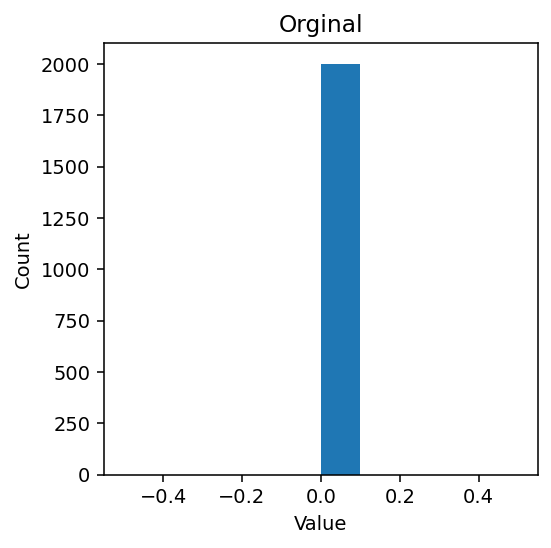

In [33]:
fig = plt.figure(figsize=(4, 4))
ax = fig.add_subplot(1, 1, 1)
ax.hist(y_cardinality)
ax.set_xlabel("Value")
ax.set_ylabel("Count")
ax.set_title("Orginal")

### Task D.5 Save the data for later use (and for testing/validation )

In [34]:
np.savez("datalog.npz", X=X, y_times=y_times, y_cardinality=y_cardinality)

---

### Task D.6 Map from query to cardinality
We are now interested in specifying a function which can map from a query (i.e. x=[c,s]) to the query cardinality for this database (i.e the Panda dataframe).

The function is pre-defined as:: 

$$f(x;\theta ) = {w_0} + {w_1}c + {w_2}s + {w_3}{c^2} + {w_4}{s^2} + {w_5}{c^3} + {w_6}{s^3} + {w_7}{c^4} + {w_8}{s^4} + {w_9}\cdot c \cdot s \,\,\,\,\,\,\,\, (Eq. 3)$$

where x is a query which is mapped through $f$ to the query cardinality. The loss defined as 

$$L\left( \theta  \right) = \frac{1}{N} \sum\limits_{n = 1}^{N=2000} {{{\left( { {y_n} - f({x_n};\theta )} \right)}^2}} $$

You should now complete four classes/methods that the database team will be using in their estimation:

- `output_process` 
- `input_process`
- `predict`
- `estimate`
- `evaluate`

**Hint**: It is recommend that you write the function in matrix form (use pen and paper) before attempting to implement it.

Any method you implement must be based on pure Python and numpy (i.e. **you cannot use scikit learn or similar tools**).


**Marking:** The overall marking is based on whether you manage to a) beat a baseline prediction, and b) come close to the correct solution. There are intermediate marks to help you along.



In [35]:
# Load the generated data from the file
# This makes it easier to mark and debug your solution at marking time
# Hint: If you struggle to generate meaningful data in the previous part you can
# copy the content of the cell to a new cell and load the file called datalog_demo.npz
# which contains pre-generated observations.

tmp = np.load("datalog.npz")
X = tmp["X"]
y_cardinality = tmp["y_cardinality"]

### Task D.7 Input and output processing
Complete the `input_process` class for preprocessing the inputs, X (e.g. normalisaiton and other transforms of X). 

- `output_process`: is already provided and you shouldn't need to modify it. 
- `input_process`: you probably need to inspect the other functions and cells below (e.g. predict) to work out what to put here.


In [36]:
class output_process:
    """
    A simple helper class which contains two functions for removing the mean of y and
    adding it at prediction time

    Requirement: y = rescale(scale(y))


    """

    y_mean = None  # these are just proposals, you can modify the variables function as you se fit depending on if and how you wish to
    y_std = None

    def __init__(self, y):
        self.y_mean = 0  # this is a trick, it is only 0 for now
        self.y_mean = np.mean(self.scale(y), axis=0)

    def scale(self, y):
        """
        A function which scales/tranforms the y values, e.g. subtracting the mean.
        """
        y_prime = y - self.y_mean
        return y_prime

    def rescale(self, y_prime):
        """
        A function which re-scales/tranforms the y_prime value back to the orginal domain (e.g. undoes the effect of scale)
        E.g., adding a constant such as the mean.

        """
        y = y_prime + self.y_mean
        y[y < 0] = 0  # avoid negative predictions
        return y

In [37]:
class input_process:
    """
    A simple class which contains two functions for processing the 2D observation of the query x=(c,s)
    and returns a potentially scaled, normalised and expanded representation.
    """

    X_mean = None  # proposal; the usage depends on you decicion to normalise X or not
    X_std = None  # proposal; the usage depends on you decicion to standardise X or not

    def __init__(self, X):
        self.X_mean = 0
        self.X_std = 1
        self.X_mean = np.mean(X, axis=0)
        self.X_std = np.std(X, axis=0)

    def process(self, X):
        """
        A function which takes the 2D in and processes the data, e.g. make a basis expansion and
        standardise the result.

        """
        res_X = (X - self.X_mean) / self.X_std
        return res_X
        # YOUR CODE HERE
        # raise NotImplementedError()
    

**Input process:**

We can apply the input process to query and observe the effect. This is the tricky bit so make sure to validate that input_process works as intended (there are no automated test to check this!).

**Note**: If you have done this the recommend/intended way, the output would not be 2D for each observations but rather 10D.

In [38]:
inprocess = input_process(X)
x_demo = inprocess.process(X[0:3, :])  # take 3 queries and see what happens to them
print(x_demo)

[[-1.29363816  0.24338355]
 [ 1.68854963  3.14140905]
 [-0.11531461 -1.52676955]]


### Task D.8 Predict 
Implement a function that can predict the cardinality, $y$, of a query $x=[c,s]$ based on Eq. (3). The parameters are stored in `theta` (i.e. $w \in \mathbb{R}^{10}$), using only linear algebra/vector operations and calls to the relevant input and output process functions (these are shown). 

The function should return the estimate of the cardinality in $y$, and the scale prediction in y_prime. It must be able to make predictions for multiple observations in `X` (i.e. `X` is a matrix).

In [39]:
def predict(X, theta, output_process, input_process):
    if input_process is not None:  # note we use None when testing/marking
        X = input_process.process(X)

    # Hint: Only a single line of code is missing
    # YOUR CODE HERE
    # raise NotImplementedError()
    y_prime = X @ theta

    if output_process is not None:  # note we use None when testing/marking
        y = output_process.rescale(y_prime)
    else:
        y = y_prime

    return y, y_prime

In [40]:
# Hidden test validating the predict function [5 Marks]
# Test which test the core functionality of the predict function (it doesn't test the input and output process)

with tick.marks(5):
    X_test = np.array([[1.2, 8.54], [2.4, 4.5]])
    theta = np.array([0.50722768, -1.32649421])
    y_test, y_prime_test = predict(X_test, theta, None, None)

    assert check_hash(y_test, ((2,), -48.182417152))
    assert check_hash(y_prime_test, ((2,), -48.182417152))


### Task D.9
Write a function which computes the [mean squared error (MSE)](https://en.wikipedia.org/wiki/Mean_squared_error) based on the difference between the predicted and true query cardinality. It should also return the [mean absolute error (MAE)](https://en.wikipedia.org/wiki/Mean_absolute_error) and the [mean absolute percentage error (MAPE)](https://en.wikipedia.org/wiki/Mean_absolute_percentage_error). Note that MAPE should be in percentage (i.e. *100).




In [41]:
def evaluate(y_pred, y_true):
    # YOUR CODE HERE
    error_mse = np.mean((y_pred - y_true)**2)
    error_mae = np.mean(np.abs(y_pred - y_true))
    error_mape = np.mean(np.abs((y_pred - y_true) / y_true)) * 100  

    # raise NotImplementedError()
    return error_mse, error_mae, error_mape

In [42]:
# Test checking the evaluate function
with tick.marks(5):
    a, b, c = evaluate(np.array([4.5, 6.2, -100.10]), np.array([14.5, -26.2, -110.10]))
    assert check_hash(a, ((), 2082.9333333333334))
    assert check_hash(b, ((), 87.33333333333333))
    assert check_hash(c, ((), 336.1871525220119))

### Task D.10
Implement a function which estimates the parameters, i.e., the $w$'s stored in `theta`, of the function based on the squared error loss defined above.

Hint: This should be done using only matrix operations and calls to the input/output process functions. You don't need numerical optimisation for this.


In [43]:
def estimate(X, y, outprocess, inprocess):
    """
    X: 2D queries/observations
    y: observed cardinality (the orginal ones, i.e. not scaled or normalised)
    outprocess: an instance of the output process class which is used to scale and rescale y
    inprocess: an instance of the input process class which is used to process the 2D input in X in a sensible way
    """
    if outprocess is not None:  # note we use None when testing/marking
        y = outprocess.scale(y)

    if inprocess is not None:  # note we use None when testing/marking
        X = inprocess.process(X)

    gram = X.T @ X
    theta = ((np.linalg.pinv(gram)) @ X.T) @ y  #这个矩阵似乎是不可逆的，得用奇异逆
    

    # Hint: 2-3 lines of code missing
    # YOUR CODE HERE
    # raise NotImplementedError()
    return theta


In [44]:
# Hidden test validating the estimate function[5 MARKS]
with tick.marks(5):
    X_test = np.array([[1.2, 8.54, 9.77], [2.4, 4.5, -33.2]])
    y_yest = np.array([1, 2])
    theta_test = estimate(X_test, y_yest, None, None)
    assert check_hash(theta_test, ((3,), 0.5095082848719855))


### Task D.11

We can now put it all together and check if we are able to make sensible fit to the data.

Note: It might be necessary to revisit your implementation above in case you do not get a sensible fit in the first attempt.


In [45]:
inprocess = input_process(X)
outprocess = output_process(y_cardinality)
theta = estimate(X, y_cardinality, outprocess, inprocess)
y_pred, y_prime_pred = predict(X, theta, outprocess, inprocess)
error_mse, error_abs, error_abs_rel = evaluate(y_pred, y_cardinality)

print("The mse error is: ", error_mse)
print("The abs error is: ", error_abs)
print("The releative abs error is [pct]: ", error_abs_rel)

The mse error is:  0.0
The abs error is:  0.0
The releative abs error is [pct]:  nan


D:\Temp\ipykernel_1612\69226597.py:5: RuntimeWarning: invalid value encountered in divide
  error_mape = np.mean(np.abs((y_pred - y_true) / y_true)) * 100


### Task D.12

To evaluate the quality of your fit it is often useful to produce visualisation to aid our analysis. For this purpose you should now:

- Create a plot of the cardinality vs the ones estimated by the model. Include a line to illustrate the ideal prediction.
- Create a figure showing the distribution of errors
- Create a figure visualising the squared error against the the query cardinality 


Note: These are not assessed per se but suggested for your benefit. They will be written to the pdf file and inspected manually.

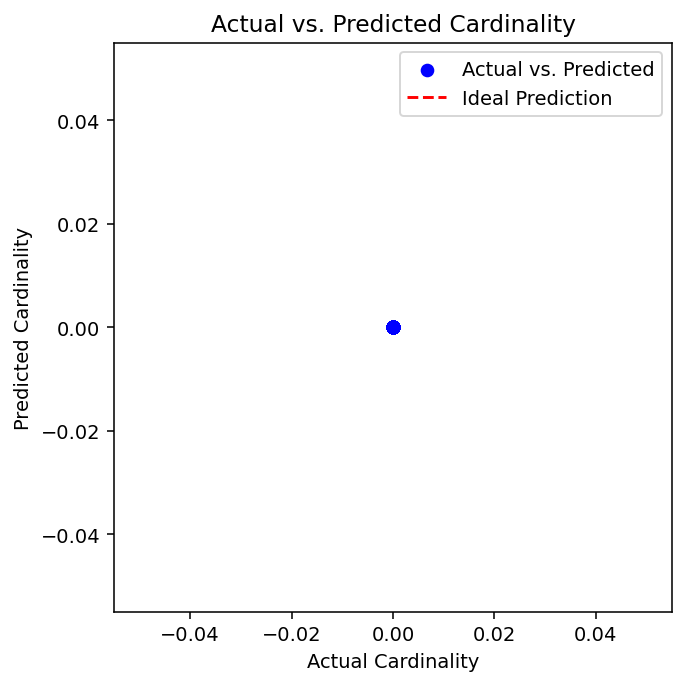

In [46]:
fig_312a = plt.figure(figsize=(5, 5))  # DO NOT CHANGE
ax_312a = (
    fig_312a.add_subplot()
)  # DO NOT CHANGE - YOU MUST ADD YOUR FIGURE TO THIS AXIS
#######################################################
# YOUR CODE HERE
# raise NotImplementedError()
ax_312a.scatter(y_cardinality, y_pred, color='blue', label='Actual vs. Predicted')
ax_312a.plot([min(y_cardinality), max(y_cardinality)], [min(y_cardinality), max(y_cardinality)], linestyle='--', color='red', label='Ideal Prediction')
ax_312a.set_xlabel('Actual Cardinality')
ax_312a.set_ylabel('Predicted Cardinality')
ax_312a.set_title('Actual vs. Predicted Cardinality')
ax_312a.legend()

# Adjust layout if necessary
plt.tight_layout()

# Show the plot
plt.show()

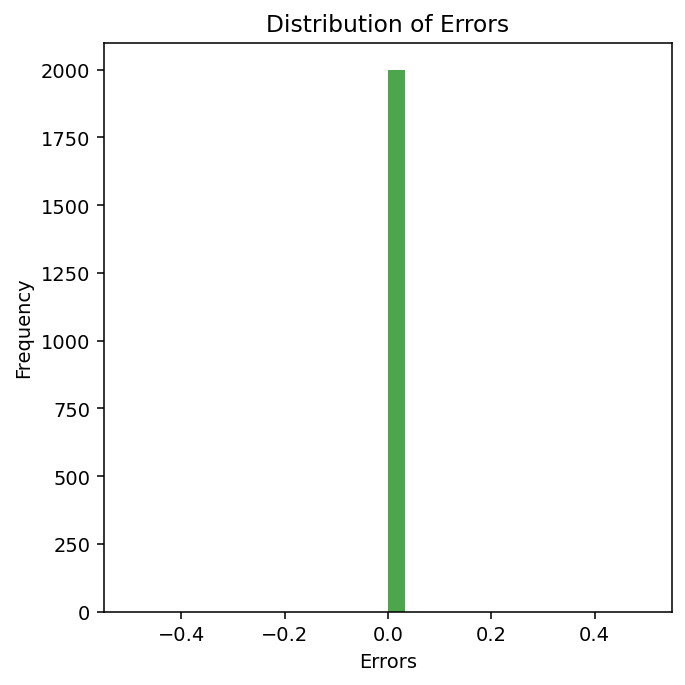

In [47]:
fig_312b = plt.figure(figsize=(5, 5))  # DO NOT CHANGE
ax_312b = fig_312b.add_subplot(
    1, 1, 1
)  # DO NOT CHANGE - YOU MUST ADD YOUR FIGURE TO THIS AXIS
#######################################################
# YOUR CODE HERE
errors = y_cardinality - y_pred
ax_312b.hist(errors, bins=30, color='green', alpha=0.7)
ax_312b.set_xlabel('Errors')
ax_312b.set_ylabel('Frequency')
ax_312b.set_title('Distribution of Errors')

# Adjust layout if necessary
plt.tight_layout()

# Show the plot
plt.show()
# raise NotImplementedError()

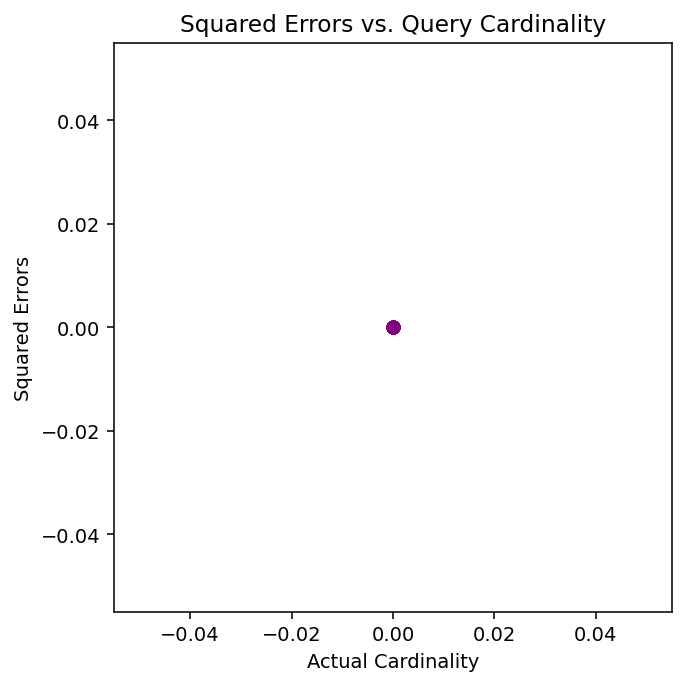

In [48]:
fig_312c = plt.figure(figsize=(5, 5))  # DO NOT CHANGE
ax_312c = fig_312c.add_subplot(
    1, 1, 1
)  # DO NOT CHANGE - YOU MUST ADD YOUR FIGURE TO THIS AXIS
#######################################################
# Plotting squared errors against query cardinality
squared_errors = (y_cardinality - y_pred) ** 2
ax_312c.scatter(y_cardinality, squared_errors, color='purple', alpha=0.7)
ax_312c.set_xlabel('Actual Cardinality')
ax_312c.set_ylabel('Squared Errors')
ax_312c.set_title('Squared Errors vs. Query Cardinality')

# Adjust layout if necessary
plt.tight_layout()

# Show the plot
plt.show()
# YOUR CODE HERE
# raise NotImplementedError()

### Task D.13 Baselines
To determine if your model is worth deploying and using for estimating the database load, your database team has requested you compare your function/fit to a naiive baseline.


The two baseline are:
- a) use the mean of the observation as the prediction for all queries 
- b) use the median of the observation as the prediction for all queries.   

Complete the `predict_average` and `predict_median` function below and compare with your predictive model.


In [49]:
def predict_average(y):
    # YOUR CODE HERE
    y_avg = np.mean(y)
    # raise NotImplementedError()
    return y_avg

In [50]:
def predict_median(y):
    # YOUR CODE HERE
    y_med = np.median(y)
    # raise NotImplementedError()
    return y_med

In [51]:
# Check that the baselines work as expected
with tick.marks(0):
    baseline_is_corrrect = False
    y_test = np.array([-3.4, 3, 6.2, 10])
    y_test_avg = predict_average(y_test)
    y_test_median = predict_median(y_test)
    assert check_hash(y_test_avg, ((), 19.75))
    assert check_hash(y_test_median, ((), 23.0))
    baseline_is_corrrect = True


In [52]:
# Evaluate the baselines

y_pred_bl = predict_average(y_cardinality)
error_mse_bl, error_abs_bl, error_abs_rel_bl = evaluate(y_pred_bl, y_cardinality)
print("The mse error is: ", error_mse_bl)
print("The abs error is: ", error_abs_bl)
print("The relative abs error is [pct]: ", error_abs_rel_bl)

y_pred_blmed = predict_median(y_cardinality)
error_mse_bl, error_abs_bl, error_abs_rel_bl = evaluate(y_pred_blmed, y_cardinality)
print("The mse error is: ", error_mse_bl)
print("The abs error is: ", error_abs_bl)
print("The relative abs error is [pct]: ", error_abs_rel_bl)

The mse error is:  0.0
The abs error is:  0.0
The relative abs error is [pct]:  nan
The mse error is:  0.0
The abs error is:  0.0
The relative abs error is [pct]:  nan


D:\Temp\ipykernel_1612\69226597.py:5: RuntimeWarning: invalid value encountered in divide
  error_mape = np.mean(np.abs((y_pred - y_true) / y_true)) * 100


Overall marking of your function...

In [53]:
# Hidden test, you get 5 marks for beating the median baseline (the baseline needs to be correct for any marks)

In [54]:
## Hidden test, you'll get 5 marks for obtaining a competetive performance close to our implementation
# You'd need munually validation that you have obtained is a sensible and competetive solution.

---

**No more assessed questions... remember to generate the pdf!**

---

-----

# Submission on Moodle


We will generate the **one** pdf file you'll need to submit **along** with the notebook. **DO NOT RENAME THE FILES!**

*Note*: you do not need to worry about the formatting etc (that's predetermined)


In [55]:
## Report generation - YOU MUST YOU RUN THIS CELL !
#
# Ignore warnings regarding fonts
#
from matplotlib.backends.backend_pdf import PdfPages

# Declaration of originality with system info
try:
    f = open("uofg_declaration_of_originality.txt", "r")
    uofg_declaration_of_originality = f.read()
except:
    uofg_declaration_of_originality = (
        "uofg_declaration_of_originality not present in cwd"
    )

try:
    student_id.lower()
except:
    student_id = "NORESPONSE"
try:
    student_typewritten_signature.lower()
except:
    student_typewritten_signature = "NORESPONSE"

fn = "idss_lab_04_dsinpractice_%s_declaration.pdf" % (student_id.lower())
fig_dec = plt.figure(figsize=(10, 12))
fig_dec.text(
    0.1,
    0.1,
    (
        "%s\n\n Student Id %s\n\n Typewritten signature: %s\n\n UUID System: %s"
        % (
            uofg_declaration_of_originality,
            student_id,
            student_typewritten_signature,
            uuid_system,
        )
    ),
)

# Combined:
fn = "idss_lab_04_dsinpractice_%s_combined_v20232024a.pdf" % (student_id)
pp = PdfPages(fn)
pp.savefig(fig_312a)
pp.savefig(fig_312b)
pp.savefig(fig_312c)
pp.savefig(fig_dec)
pp.close()

with tick.marks(
    0
):  # have you generated the combined file...? you don't actually get any credit for this; just confirmation that the file has been generated
    assert os.path.exists(fn)

<Figure size 1400x1680 with 0 Axes>

**You must (for full or partial marks) submit TWO files via Moodle:**

- this notebook (completed) after "Restart and rerun all":
    - `idss_lab_04_dsinpractice_v20232024a.ipynb`
    
- the combined pdf (autogenerated) containing the relevant figures and answers for the manual marking:
     - `idss_lab_04_dsinpractice_[YOUR STUDENT ID]_combined_v20232024a.pdf`)     
    


---

# Appendix: Marking Summary (and other metadata)
**Make sure the notebook runs without errors (remove/resolve the `raise NotImplementedError()`) and "Restart and Rerun All" cells to get a correct indication of your marks.**

In [56]:
print("Marks total : ", "100")
print("Marks visible (with immediate feedback): ", "65")
print("Marks hidden (without immediate feedback): ", "35")
print(
    "\nThe fraction below displays your performance on the autograded part of the lab that's visible with feedback (only valid after `Restart and Run all`:"
)
tick.summarise_marks()  #

Marks total :  100
Marks visible (with immediate feedback):  65
Marks hidden (without immediate feedback):  35

The fraction below displays your performance on the autograded part of the lab that's visible with feedback (only valid after `Restart and Run all`:


---